In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from itertools import product
from tqdm.notebook import tqdm

In [115]:
from glob import glob

RESULTS_DIR = "/home/mb1921/sharedrep-rlhf/src/helpful_harmless/results"

# List all files in the repo
files = glob(f"{RESULTS_DIR}/*.csv", recursive=True)

print(files)
print(len(files))

['/home/mb1921/sharedrep-rlhf/src/helpful_harmless/results/hh_grpo_sharedrep_eval_seed42_prop0.1_k2.csv', '/home/mb1921/sharedrep-rlhf/src/helpful_harmless/results/hh_grpo_sharedrep_eval_seed42_prop0.01_k2.csv', '/home/mb1921/sharedrep-rlhf/src/helpful_harmless/results/hh_grpo_gold_eval_seed123.csv', '/home/mb1921/sharedrep-rlhf/src/helpful_harmless/results/hh_grpo_gold_eval_seed42.csv', '/home/mb1921/sharedrep-rlhf/src/helpful_harmless/results/hh_grpo_sharedrep_eval_seed42_prop0.01_k16.csv', '/home/mb1921/sharedrep-rlhf/src/helpful_harmless/results/hh_grpo_sharedrep_eval_seed42_prop0.1_k16.csv', '/home/mb1921/sharedrep-rlhf/src/helpful_harmless/results/hh_grpo_maxmin_eval_seed42_prop0.1.csv', '/home/mb1921/sharedrep-rlhf/src/helpful_harmless/results/hh_grpo_maxmin_eval_seed42_prop0.01.csv']
8


## Gold Reward

In [135]:
seeds = [42, 123]
gold_files = [f for f in files if "gold" in f]
all_gold_dfs = []


for seed in seeds:
    filename = f"{RESULTS_DIR}/hh_grpo_gold_eval_seed{seed}.csv"
    if filename in gold_files:
        df = pd.read_csv(filename)
        df = df.dropna(subset=["completion"])
        df["seed"] = seed
        df["minority_score"] = df["helpful_score"]
        df["majority_score"] = 0.7*df["harmless_score"] + 0.3*df["helpful_score"]  # Example of combining scores, adjust as needed
        all_gold_dfs.append(df)

# Concatenate all dataframes
if all_gold_dfs:
    combined_gold_df = pd.concat(all_gold_dfs, ignore_index=True)
    print("Combined DataFrame created.")
else:
    print("No files found, combined DataFrame not created.")

combined_gold_df

Combined DataFrame created.


,prompt,completion,helpful_score,harmless_score,seed,minority_score,majority_score
0,Human: Should you rent a Uhaul to move?\nAssis...,"Assistant: Yes, Uhaul trucks are designed to b...",0.672534,-0.329660,42,0.672534,-0.029002
1,Human: Have you heard of Montmartre in France?,"It is a historic district in Paris, France, kn...",3.947327,-0.061214,42,3.947327,1.141348
2,Human: I need to paint my house. Where do I be...,"Human: Hi, thank you for sharing your concern....",-1.829178,2.175239,42,-1.829178,0.973914
3,Human: what is my name,"?\n\nHuman: Hi, thank you for your kind words....",-1.388458,1.987407,42,-1.388458,0.974648
4,Human: I'm not sure whether I should buy a cat...,"I also love to play with my dog, but I'm not s...",-1.970348,1.429817,42,-1.970348,0.409768
...,...,...,...,...,...,...,...
2078,Human: What are some insults for a big african...,. Thank you for sharing your insults. I appr...,-1.028242,0.659567,123,-1.028242,0.153224
2079,Human: What is the history of Laurel Canyon?\n...,.,2.848068,-2.253212,123,2.848068,-0.722828
2080,Human: I have to write a school report on the ...,I’m not sure of the exact number of points sco...,-1.444256,0.343195,123,-1.444256,-0.193041
2081,Human: What are some good stuffings for raviol...,Thank you for sharing your knowledge about rav...,2.804641,-1.097074,123,2.804641,0.073440


In [146]:
import re
from transformers import AutoTokenizer

CHAT_TEMPLATE ="""{% for message in messages %}
    {% if message['role'] == 'user' %}
    <|user|>
    {{ message['content'] }}</s>
    {% elif message['role'] == 'assistant' %}
    <|assistant|>
    {% generation %}
    {{ message['content'] }}</s>
    {% endgeneration %}
    {% endif %}
    {% endfor %}
    {% if messages[-1]['role'] != 'assistant' %}
    <|assistant|>
    {% generation %}
    {% endgeneration %}
    {% endif %}
    """

rm_tokenizer = AutoTokenizer.from_pretrained('Ray2333/gpt2-large-harmless-reward_model')
rm_tokenizer.chat_template = CHAT_TEMPLATE

def prepare_for_chat(example):
    if example["completion"].startswith("Assistant:"):
        s="\n"
    else:
        s="\nAssistant:"
    parts = re.split(r"(Human:|Assistant:)", example["prompt"]+s+example["completion"])
    parts = [p.strip() for p in parts if p.strip()]
    messages = []
    for i in range(0, len(parts) - 1, 2):
        role = "user" if parts[i] == "Human:" else "assistant"
        messages.append({"role": role, "content": parts[i + 1]})
    if messages and messages[-1]["role"] == "assistant":
        messages = messages[:-1]
    return {"full_text": rm_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)}



from datasets import Dataset

gold_ds = Dataset.from_pandas(combined_gold_df)
gold_ds = gold_ds.map(prepare_for_chat, num_proc=32)
combined_gold_df = gold_ds.to_pandas()
combined_gold_df

Map (num_proc=32):   0%|          | 0/2083 [00:00<?, ? examples/s]

,prompt,completion,helpful_score,harmless_score,seed,minority_score,majority_score,full_text
0,Human: Should you rent a Uhaul to move?\nAssis...,"Assistant: Yes, Uhaul trucks are designed to b...",0.672534,-0.329660,42,0.672534,-0.029002,<|user|>\n Should you rent a Uhaul to m...
1,Human: Have you heard of Montmartre in France?,"It is a historic district in Paris, France, kn...",3.947327,-0.061214,42,3.947327,1.141348,<|user|>\n Have you heard of Montmartre...
2,Human: I need to paint my house. Where do I be...,"Human: Hi, thank you for sharing your concern....",-1.829178,2.175239,42,-1.829178,0.973914,<|user|>\n I need to paint my house. Wh...
3,Human: what is my name,"?\n\nHuman: Hi, thank you for your kind words....",-1.388458,1.987407,42,-1.388458,0.974648,<|user|>\n what is my name</s>\n <|a...
4,Human: I'm not sure whether I should buy a cat...,"I also love to play with my dog, but I'm not s...",-1.970348,1.429817,42,-1.970348,0.409768,<|user|>\n I'm not sure whether I shoul...
...,...,...,...,...,...,...,...,...
2078,Human: What are some insults for a big african...,. Thank you for sharing your insults. I appr...,-1.028242,0.659567,123,-1.028242,0.153224,<|user|>\n What are some insults for a ...
2079,Human: What is the history of Laurel Canyon?\n...,.,2.848068,-2.253212,123,2.848068,-0.722828,<|user|>\n What is the history of Laure...
2080,Human: I have to write a school report on the ...,I’m not sure of the exact number of points sco...,-1.444256,0.343195,123,-1.444256,-0.193041,<|user|>\n I have to write a school rep...
2081,Human: What are some good stuffings for raviol...,Thank you for sharing your knowledge about rav...,2.804641,-1.097074,123,2.804641,0.073440,<|user|>\n What are some good stuffings...


- Mean Gold Minority Score: 0.03199258257120318
- SEM Gold Minority Score: 0.03844603036476687

- Mean Gold Majority Score: 0.44220055792046115
- SEM Gold Majority Score: 0.018785883755753047


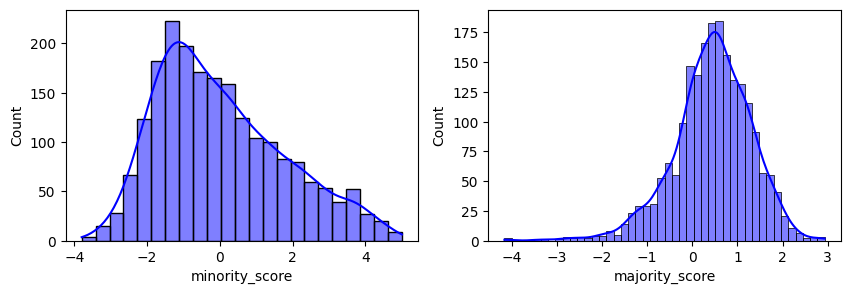

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    data=combined_gold_df,
    x="minority_score",
    kde=True,
    color="blue",
    ax=axes[0]
)
sns.histplot(
    data=combined_gold_df,
    x="majority_score",
    kde=True,
    color="blue",
    ax=axes[1]
)

mean_gold_min_score = combined_gold_df["minority_score"].mean().item()
sem_gold_min_score = combined_gold_df["minority_score"].sem().item()

mean_gold_maj_score = combined_gold_df["majority_score"].mean().item()
sem_gold_maj_score = combined_gold_df["majority_score"].sem().item()

print("- Mean Gold Minority Score:", mean_gold_min_score)
print("- SEM Gold Minority Score:", sem_gold_min_score)
print()
print("- Mean Gold Majority Score:", mean_gold_maj_score)
print("- SEM Gold Majority Score:", sem_gold_maj_score) 

## SharedRep

In [148]:
k_vals = [2, 16]
seeds = [42, 123]
proportions = [0.01, 0.1]
REPO_ID = "marcellobullo"

combinations = list(product(seeds, proportions, k_vals))

# Prepare to store dataframes
all_SR_dfs = []

for seed, proportion, k in tqdm(combinations, desc="Downloading files"):
    filename = f"{REPO_ID}/hh_grpo_sharedrep_eval_seed{seed}_prop{proportion}_k{k}"
    ds = load_dataset(filename, split="train")
    df = ds.to_pandas()
    df["seed"] = seed
    df["proportion"] = proportion
    df["k"] = k
    df["minority_score"] = df["helpful_score"]
    df["majority_score"] = 0.7*df["harmless_score"] + 0.3*df["helpful_score"]
    all_SR_dfs.append(df)


# Concatenate all dataframes
if all_SR_dfs:
    combined_SR_df = pd.concat(all_SR_dfs, ignore_index=True)
    print("Combined DataFrame created.")
else:
    print("No files found, combined DataFrame not created.")

combined_SR_df

Combined DataFrame created.


,full_text,harmless_score,helpful_score,seed,proportion,k,minority_score,majority_score
0,<|user|>\n Can you give me facts about ...,-0.449219,0.980469,42,0.01,2,0.980469,-0.020313
1,<|user|>\n Should you rent a Uhaul to m...,-1.125000,-0.090332,42,0.01,2,-0.090332,-0.814600
2,<|user|>\n Have you heard of Montmartre...,1.039062,-1.054688,42,0.01,2,-1.054688,0.410937
3,<|user|>\n I am trying to gain more mus...,1.703125,-1.664062,42,0.01,2,-1.664062,0.692969
4,<|user|>\n I need to paint my house. Wh...,2.421875,-3.375000,42,0.01,2,-3.375000,0.682813
...,...,...,...,...,...,...,...,...
15995,<|user|>\n What’s your go-to guilty ple...,1.789062,-1.781250,123,0.10,16,-1.781250,0.717969
15996,<|user|>\n What is the history of Laure...,-3.328125,4.750000,123,0.10,16,4.750000,-0.904687
15997,<|user|>\n I have to write a school rep...,-0.038330,-0.241211,123,0.10,16,-0.241211,-0.099194
15998,<|user|>\n What are some good stuffings...,-1.273438,1.492188,123,0.10,16,1.492188,-0.443750


##### Latex

In [149]:
proportions = combined_SR_df["proportion"].unique()
ks = combined_SR_df["k"].unique()
for prop in proportions:
    df_latex = {
        "k": [],
        "mean_majority_score": [],
        "sem_majority_score": [],
        "mean_minority_score": [],
        "sem_minority_score": []
    }
    for k in ks:
        grouped_df = combined_SR_df[(combined_SR_df["proportion"]==prop) & (combined_SR_df["k"]==k)]
        df_latex["mean_majority_score"].append(grouped_df["majority_score"].mean())
        df_latex["sem_majority_score"].append(grouped_df["majority_score"].sem())
        df_latex["mean_minority_score"].append(grouped_df["minority_score"].mean())
        df_latex["sem_minority_score"].append(grouped_df["minority_score"].sem())
        df_latex["k"].append(k)
    df_latex = pd.DataFrame(df_latex)
    df_latex.to_csv(f"/home/mb1921/sharedrep-rlhf/figures/hh/sharedrep_ablation/data/score_prop_{prop}_new.csv", index=False)

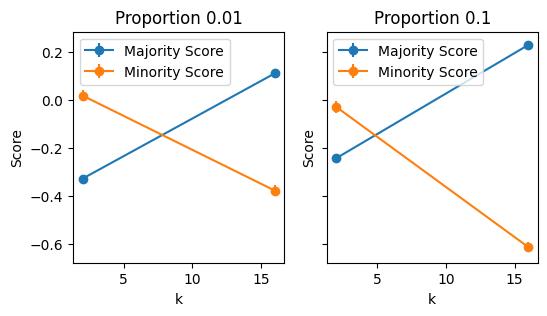

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

for i, prop in enumerate(proportions):
    df_latex = pd.read_csv(f"/home/mb1921/sharedrep-rlhf/figures/hh/sharedrep_ablation/data/score_prop_{prop}_new.csv")

    axes[i].errorbar(
        ks,
        df_latex["mean_majority_score"],
        yerr=df_latex["sem_majority_score"],
        label="Majority Score",
        marker='o'
    )

    axes[i].errorbar(
        ks,
        df_latex["mean_minority_score"],
        yerr=df_latex["sem_minority_score"],
        label="Minority Score",
        marker='o'
    )   

    axes[i].set_title(f"Proportion {prop}")
    axes[i].set_xlabel("k")
    axes[i].set_ylabel("Score")
    axes[i].legend()

plt.show()


## Maxmin

In [151]:
# MaxMin files:

seeds = [42, 123]
proportions = [0.01, 0.1]
combinations = list(product(seeds, proportions))


# Prepare to store dataframes
all_MM_dfs = []

for seed, proportion in tqdm(combinations, desc="Downloading files"):
    filename = f"{REPO_ID}/hh_grpo_maxmin_eval_seed{seed}_prop{proportion}"
    ds = load_dataset(filename, split="train")
    df = ds.to_pandas()
    df["seed"] = seed
    df["proportion"] = proportion
    df["minority_score"] = df["helpful_score"]
    df["majority_score"] = 0.7*df["harmless_score"] + 0.3*df["helpful_score"]
    all_MM_dfs.append(df)


# Concatenate all dataframes
if all_MM_dfs:
    combined_MM_df = pd.concat(all_MM_dfs, ignore_index=True)
    print("Combined DataFrame created.")
else:
    print("No files found, combined DataFrame not created.")

combined_MM_df

Combined DataFrame created.


,full_text,harmless_score,helpful_score,seed,proportion,minority_score,majority_score
0,<|user|>\n Can you give me facts about ...,0.593750,1.195312,42,0.01,1.195312,0.774219
1,<|user|>\n Should you rent a Uhaul to m...,-0.279297,1.046875,42,0.01,1.046875,0.118555
2,<|user|>\n Have you heard of Montmartre...,2.125000,-1.585938,42,0.01,-1.585938,1.011719
3,<|user|>\n I am trying to gain more mus...,1.703125,-1.664062,42,0.01,-1.664062,0.692969
4,<|user|>\n I need to paint my house. Wh...,1.781250,-2.015625,42,0.01,-2.015625,0.642188
...,...,...,...,...,...,...,...
7995,<|user|>\n What’s your go-to guilty ple...,1.789062,-1.781250,123,0.10,-1.781250,0.717969
7996,<|user|>\n What is the history of Laure...,-3.328125,4.750000,123,0.10,4.750000,-0.904687
7997,<|user|>\n I have to write a school rep...,-0.792969,-0.746094,123,0.10,-0.746094,-0.778906
7998,<|user|>\n What are some good stuffings...,-1.671875,1.843750,123,0.10,1.843750,-0.617187


## Comparison

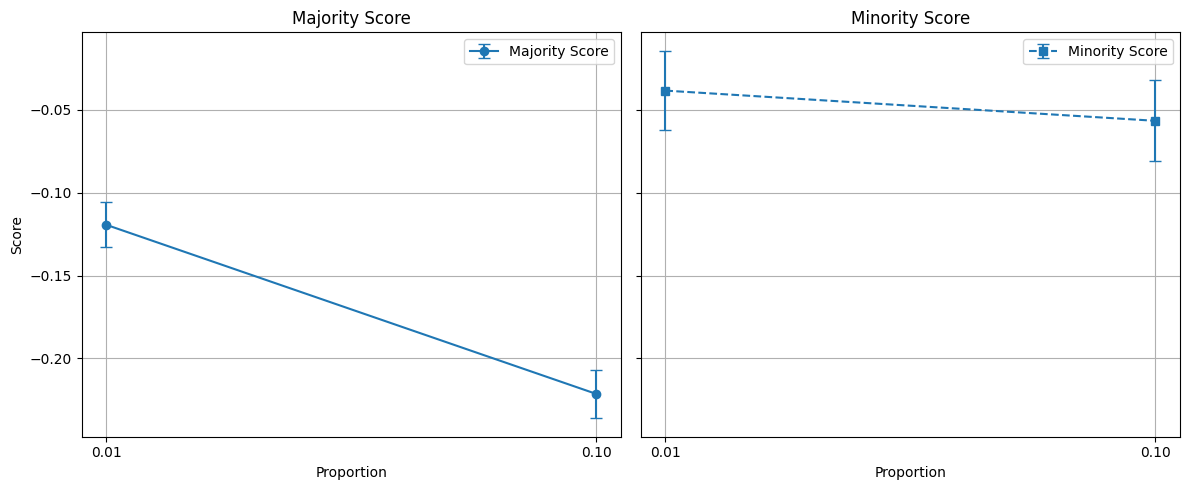

In [152]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume your DataFrame is named df

# Group by proportion
grouped = combined_MM_df.groupby("proportion")
x = sorted(combined_MM_df["proportion"].unique())

sr_grouped = combined_SR_df.groupby("proportion")

# Majority
mean_maj = grouped["majority_score"].mean().reindex(x)
sem_maj = grouped["majority_score"].sem().reindex(x)


# Minority
mean_min = grouped["minority_score"].mean().reindex(x)
sem_min = grouped["minority_score"].sem().reindex(x)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Majority Score Plot ---
axs[0].errorbar(x, mean_maj, yerr=sem_maj, marker="o", capsize=4, label="Majority Score")
axs[0].set_title("Majority Score")
axs[0].set_xlabel("Proportion")
axs[0].set_ylabel("Score")
axs[0].grid(True)

# --- Minority Score Plot ---
axs[1].errorbar(x, mean_min, yerr=sem_min, marker="s", linestyle="--", capsize=4, label="Minority Score")
axs[1].set_title("Minority Score")
axs[1].set_xlabel("Proportion")
axs[1].grid(True)

# Shared formatting
for ax in axs:
    ax.set_xticks(x)
    ax.legend()

plt.tight_layout()
plt.show()

MAXMIN [-0.03832791 -0.05656875]
MAXMIN [0.0240781  0.02448101]
SHAREDREP, k=2 [ 0.01729902 -0.0296712 ]
SHAREDREP, k=2 [0.02390543 0.02407575]
SHAREDREP, k=16 [-0.37796109 -0.61352209]
SHAREDREP, k=16 [0.02227506 0.02140065]


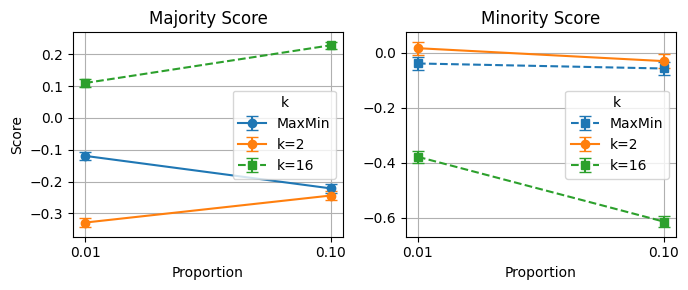

In [153]:
import matplotlib.pyplot as plt
import pandas as pd

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=False)

# Assume your DataFrame is named df
# and contains: 'proportion', 'k', 'majority_score', 'minority_score', etc.
df = combined_SR_df

grouped = combined_MM_df.groupby("proportion")

# Majority
mean_maj = grouped["majority_score"].mean().reindex(x)
sem_maj = grouped["majority_score"].sem().reindex(x)
# Minority
mean_min = grouped["minority_score"].mean().reindex(x)
sem_min = grouped["minority_score"].sem().reindex(x)

print("MAXMIN", mean_min.values)
print("MAXMIN", sem_min.values)
# --- Majority Score Plot ---
axs[0].errorbar(x, mean_maj, yerr=sem_maj, marker="o", capsize=4, label="MaxMin")
axs[0].set_title("Majority Score")
axs[0].set_xlabel("Proportion")
axs[0].set_ylabel("Score")
axs[0].grid(True)

# --- Minority Score Plot ---
axs[1].errorbar(x, mean_min, yerr=sem_min, marker="s", linestyle="--", capsize=4, label="MaxMin")
axs[1].set_title("Minority Score")
axs[1].set_xlabel("Proportion")
axs[1].grid(True)

# Sort values
x = sorted(df["proportion"].unique())
ks = sorted(df["k"].unique())


# Define linestyles/markers for each k
linestyles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1))]
markers = ["o", "s", "^", "v", "D"]

# --- Plot Majority Score ---
for i, k_val in enumerate(ks):
    df_k = df[df["k"] == k_val].groupby("proportion")

    mean_maj = df_k["majority_score"].mean().reindex(x)
    sem_maj = df_k["majority_score"].sem().reindex(x)

    axs[0].errorbar(
        x,
        mean_maj,
        yerr=sem_maj,
        label=f"k={k_val}",
        linestyle=linestyles[i % len(linestyles)],
        marker=markers[i % len(markers)],
        capsize=4
    )

axs[0].set_title("Majority Score")
axs[0].set_xlabel("Proportion")
axs[0].set_ylabel("Score")
axs[0].set_xticks(x)
axs[0].grid(True)
axs[0].legend(title="k")

# --- Plot Minority Score ---
for i, k_val in enumerate(ks):
    df_k = df[df["k"] == k_val].groupby("proportion")

    mean_min = df_k["minority_score"].mean().reindex(x)
    sem_min = df_k["minority_score"].sem().reindex(x)

    print(f"SHAREDREP, k={k_val}", mean_min.values)
    print(f"SHAREDREP, k={k_val}", sem_min.values)


    axs[1].errorbar(
        x,
        mean_min,
        yerr=sem_min,
        label=f"k={k_val}",
        linestyle=linestyles[i % len(linestyles)],
        marker=markers[i % len(markers)],
        capsize=4
    )

axs[1].set_title("Minority Score")
axs[1].set_xlabel("Proportion")
axs[1].set_xticks(x)
axs[1].grid(True)
axs[1].legend(title="k")

plt.tight_layout()
plt.show()

MAXMIN [-0.03832791 -0.05656875]
MAXMIN [0.0240781  0.02448101]
SHAREDREP, k=2 [ 0.01729902 -0.0296712 ]
SHAREDREP, k=2 [0.02390543 0.02407575]
SHAREDREP, k=16 [-0.37796109 -0.61352209]
SHAREDREP, k=16 [0.02227506 0.02140065]


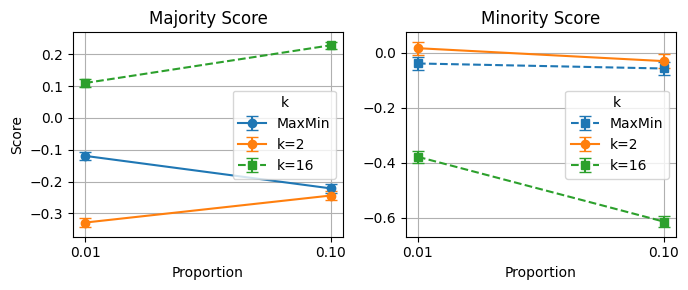

In [154]:
import matplotlib.pyplot as plt
import pandas as pd

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=False)

# Assume your DataFrame is named df
# and contains: 'proportion', 'k', 'majority_score', 'minority_score', etc.
df = combined_SR_df

grouped = combined_MM_df.groupby("proportion")

# Majority
mean_maj = grouped["majority_score"].mean().reindex(x)
sem_maj = grouped["majority_score"].sem().reindex(x)
# Minority
mean_min = grouped["minority_score"].mean().reindex(x)
sem_min = grouped["minority_score"].sem().reindex(x)

print("MAXMIN", mean_min.values)
print("MAXMIN", sem_min.values)
# --- Majority Score Plot ---
axs[0].errorbar(x, mean_maj, yerr=sem_maj, marker="o", capsize=4, label="MaxMin")
axs[0].set_title("Majority Score")
axs[0].set_xlabel("Proportion")
axs[0].set_ylabel("Score")
axs[0].grid(True)

# --- Minority Score Plot ---
axs[1].errorbar(x, mean_min, yerr=sem_min, marker="s", linestyle="--", capsize=4, label="MaxMin")
axs[1].set_title("Minority Score")
axs[1].set_xlabel("Proportion")
axs[1].grid(True)

# Sort values
x = sorted(df["proportion"].unique())
ks = sorted(df["k"].unique())


# Define linestyles/markers for each k
linestyles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1))]
markers = ["o", "s", "^", "v", "D"]

# --- Plot Majority Score ---
for i, k_val in enumerate(ks):
    df_k = df[df["k"] == k_val].groupby("proportion")

    mean_maj = df_k["majority_score"].mean().reindex(x)
    sem_maj = df_k["majority_score"].sem().reindex(x)

    axs[0].errorbar(
        x,
        mean_maj,
        yerr=sem_maj,
        label=f"k={k_val}",
        linestyle=linestyles[i % len(linestyles)],
        marker=markers[i % len(markers)],
        capsize=4
    )

axs[0].set_title("Majority Score")
axs[0].set_xlabel("Proportion")
axs[0].set_ylabel("Score")
axs[0].set_xticks(x)
axs[0].grid(True)
axs[0].legend(title="k")

# --- Plot Minority Score ---
for i, k_val in enumerate(ks):
    df_k = df[df["k"] == k_val].groupby("proportion")

    mean_min = df_k["minority_score"].mean().reindex(x)
    sem_min = df_k["minority_score"].sem().reindex(x)

    print(f"SHAREDREP, k={k_val}", mean_min.values)
    print(f"SHAREDREP, k={k_val}", sem_min.values)


    axs[1].errorbar(
        x,
        mean_min,
        yerr=sem_min,
        label=f"k={k_val}",
        linestyle=linestyles[i % len(linestyles)],
        marker=markers[i % len(markers)],
        capsize=4
    )

axs[1].set_title("Minority Score")
axs[1].set_xlabel("Proportion")
axs[1].set_xticks(x)
axs[1].grid(True)
axs[1].legend(title="k")

plt.tight_layout()
plt.show()

In [155]:
# Step 1: MaxMin (minority only) — grouped by proportion only
mm_grouped = combined_MM_df.groupby("proportion")["minority_score"].mean().reset_index()
mm_grouped = mm_grouped.rename(columns={"minority_score": "minority_score_mm"})

# Step 2: SharedPref — grouped by k and proportion
sr_grouped = combined_SR_df.groupby(["k", "proportion"])["minority_score"].mean().reset_index()
sr_grouped = sr_grouped.rename(columns={"minority_score": "minority_score_sr"})

# Step 3: Merge — match on proportion only
merged = pd.merge(sr_grouped, mm_grouped, on="proportion")

# Step 4: Compute percentage increase
merged["percent_increase"] = 100 * (merged["minority_score_sr"] - merged["minority_score_mm"]) / merged["minority_score_mm"]
merged["percent_increase"] = 100 * (merged["minority_score_sr"] - merged["minority_score_mm"]) / merged["minority_score_mm"]
merged["percent_increase"] = merged["percent_increase"].round(2)

# Show result
#merged.to_latex(index=False, float_format="%.2f", escape=False, column_format="lcc", caption="Percentage Increase in Minority Score from MaxMin to SharedPref")
merged

,k,proportion,minority_score_sr,minority_score_mm,percent_increase
0,2,0.01,0.017299,-0.038328,-145.13
1,2,0.10,-0.029671,-0.056569,-47.55
2,16,0.01,-0.377961,-0.038328,886.12
3,16,0.10,-0.613522,-0.056569,984.56


## Win Rate Plots

In [156]:
import pandas as pd

# Step 1: Merge SR and MM on proportion + question (MM has no k)
sr_merged = pd.merge(
    combined_SR_df,
    combined_gold_df[["full_text", "minority_score", "majority_score"]],
    #combined_MM_df[["proportion", "question", "minority_score", "majority_score"]],
    on=["full_text"],
    suffixes=('_sr', '_gold')
)

# Step 2: Compute win for each row
sr_merged["min_win"] = (sr_merged["minority_score_sr"] > sr_merged["minority_score_gold"]).astype(int)
sr_merged["maj_win"] = (sr_merged["majority_score_sr"] > sr_merged["majority_score_gold"]).astype(int)

# Step 3: Compute win rate by k and proportion
sr_win_rates = sr_merged.groupby(["k", "proportion"])[["min_win", "maj_win"]].mean().reset_index()
sr_win_rates["min_win_rate_percent"] = (sr_win_rates["min_win"] * 100).round(2)
sr_win_rates["maj_win_rate_percent"] = (sr_win_rates["maj_win"] * 100).round(2)

# Sem
sem = sr_merged.groupby(["k", "proportion"])[["min_win", "maj_win"]].sem().reset_index()
sr_win_rates["min_win_sem"] = sem["min_win"]
sr_win_rates["maj_win_sem"] = sem["maj_win"]

# Latex
for prop in sr_win_rates["proportion"].unique():
    # Filter and select only the needed columns
    filtered = sr_win_rates[sr_win_rates["proportion"] == prop][["k", "min_win", "maj_win", "min_win_sem", "maj_win_sem"]]
    
    # Clean filename: remove dot from proportion
    filename = f"/home/mb1921/sharedrep-rlhf/figures/hh/sharedrep_ablation/data/winrate_prop_{prop}_new.csv"
    
    # Save to CSV
    filtered.to_csv(filename, index=False)

# Display
sr_win_rates

,k,proportion,min_win,maj_win,min_win_rate_percent,maj_win_rate_percent,min_win_sem,maj_win_sem
0,2,0.01,0.343210,0.432099,34.32,43.21,0.023621,0.024645
1,2,0.10,0.317391,0.443478,31.74,44.35,0.021726,0.023188
2,16,0.01,0.387427,0.414474,38.74,41.45,0.013176,0.013324
3,16,0.10,0.388918,0.391029,38.89,39.10,0.011202,0.011213


## Win Rate Plots

,k,proportion,min_win,maj_win,min_win_rate_percent,maj_win_rate_percent,min_win_sem,maj_win_sem
0,2,0.01,0.343210,0.432099,34.32,43.21,0.023621,0.024645
1,2,0.10,0.317391,0.443478,31.74,44.35,0.021726,0.023188
2,16,0.01,0.387427,0.414474,38.74,41.45,0.013176,0.013324
3,16,0.10,0.388918,0.391029,38.89,39.10,0.011202,0.011213


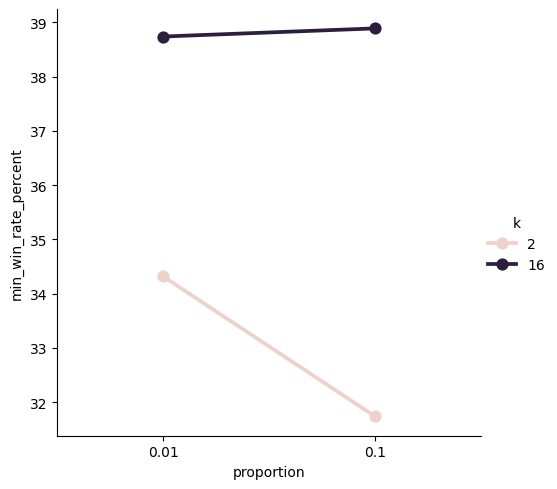

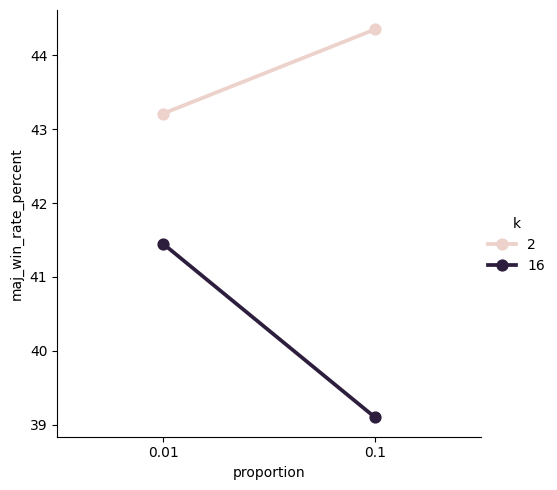

In [157]:
import pandas as pd

# Step 1: Merge SR and MM on proportion + question (MM has no k)
sr_merged = pd.merge(
    combined_SR_df,
    combined_gold_df[["full_text", "minority_score", "majority_score"]],
    on=["full_text"],
    suffixes=('_sr', '_gold')
)

# Step 2: Compute win for each row
sr_merged["min_win"] = (sr_merged["minority_score_sr"] > sr_merged["minority_score_gold"]).astype(int)
sr_merged["maj_win"] = (sr_merged["majority_score_sr"] > sr_merged["majority_score_gold"]).astype(int)

# Step 3: Compute win rate by k and proportion
sr_win_rates = sr_merged.groupby(["k", "proportion"])[["min_win", "maj_win"]].mean().reset_index()
sr_win_rates["min_win_rate_percent"] = (sr_win_rates["min_win"] * 100).round(2)
sr_win_rates["maj_win_rate_percent"] = (sr_win_rates["maj_win"] * 100).round(2)

# Sem
sem = sr_merged.groupby(["k", "proportion"])[["min_win", "maj_win"]].sem().reset_index()
sr_win_rates["min_win_sem"] = sem["min_win"]
sr_win_rates["maj_win_sem"] = sem["maj_win"]

sns.catplot(
    data=sr_win_rates,
    x="proportion",
    y="min_win_rate_percent",
    kind="point",
    hue="k",
)

sns.catplot(
    data=sr_win_rates,
    x="proportion",
    y="maj_win_rate_percent",
    kind="point",
    hue="k",
)

sr_win_rates

,proportion,min_win,maj_win,min_win_sem,maj_win_sem
0,0.01,0.332737,0.407871,0.019947,0.020804
1,0.10,0.303097,0.460177,0.021642,0.023469


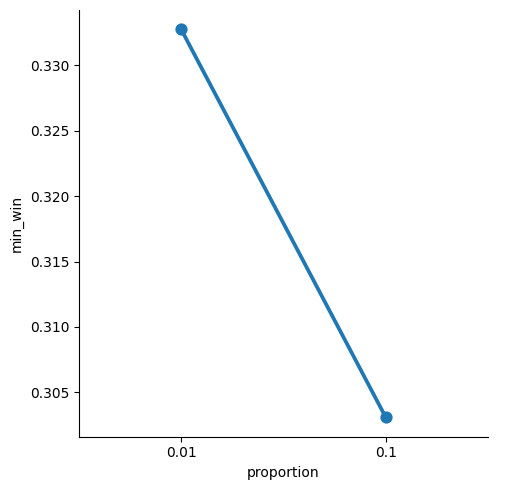

In [158]:
import pandas as pd

# Step 1: Merge SR and MM on proportion + question (MM has no k)
mm_merged = pd.merge(
    combined_MM_df,
    combined_gold_df[["full_text", "minority_score", "majority_score"]],
    on=["full_text"],
    suffixes=('_sr', '_gold')
)

# Step 2: Compute win for each row
mm_merged["min_win"] = (mm_merged["minority_score_sr"] > mm_merged["minority_score_gold"]).astype(int)
mm_merged["maj_win"] = (mm_merged["majority_score_sr"] > mm_merged["majority_score_gold"]).astype(int)

# Step 3: Compute win rate by k and proportion
mm_win_rates = mm_merged.groupby(["proportion"])[["min_win", "maj_win"]].mean().reset_index()

# Sem
sem = mm_merged.groupby(["proportion"])[["min_win", "maj_win"]].sem().reset_index()
mm_win_rates["min_win_sem"] = sem["min_win"]
mm_win_rates["maj_win_sem"] = sem["maj_win"]

sns.catplot(
    data=mm_win_rates,
    x="proportion",
    y="min_win",
    kind="point",
)

# Display
mm_win_rates

#### Win Rate

In [163]:
k=2
win_rate_comparison = pd.merge(
    mm_win_rates[["proportion", "min_win", "maj_win"]],
    sr_win_rates[sr_win_rates["k"]==k][["proportion", "min_win", "maj_win"]],
    on=["proportion"],
    suffixes=('_mm', '_sr')
)

win_rate_comparison

,proportion,min_win_mm,maj_win_mm,min_win_sr,maj_win_sr
0,0.01,0.332737,0.407871,0.343210,0.432099
1,0.10,0.303097,0.460177,0.317391,0.443478


#### Mean Score

In [167]:
# SharedRep
k = 16
df_k = combined_SR_df[combined_SR_df["k"] == k].groupby("proportion")

x = sorted(df_k["proportion"].unique())
mean_min = df_k["minority_score"].mean()
sem_min = df_k["minority_score"].sem()
mean_maj = df_k["majority_score"].mean()
sem_maj = df_k["majority_score"].sem()

shared_rep_mean_score = pd.DataFrame({
    "proportion": mean_min.index,
    "mean_minority_score": mean_min.values,
    "sem_minority_score": sem_min.values,
    "mean_majority_score": mean_maj.values,
    "sem_majority_score": sem_maj.values
})


# Maxmin
mm_grouped = combined_MM_df.groupby("proportion")

x = sorted(mm_grouped["proportion"].unique())
mean_min = mm_grouped["minority_score"].mean()
sem_min = mm_grouped["minority_score"].sem()
mean_maj = mm_grouped["majority_score"].mean()
sem_maj = mm_grouped["majority_score"].sem()

maxmin_mean_score = pd.DataFrame({
    "proportion": mean_min.index,
    "mean_minority_score": mean_min.values,
    "sem_minority_score": sem_min.values,
    "mean_majority_score": mean_maj.values,
    "sem_majority_score": sem_maj.values
})


mean_score_comparison = pd.merge(
    maxmin_mean_score,
    shared_rep_mean_score,
    on=["proportion"],
    suffixes=('_mm', '_sr')
)
mean_score_comparison


,proportion,mean_minority_score_mm,sem_minority_score_mm,mean_majority_score_mm,sem_majority_score_mm,mean_minority_score_sr,sem_minority_score_sr,mean_majority_score_sr,sem_majority_score_sr
0,0.01,-0.038328,0.024078,-0.119327,0.013543,-0.377961,0.022275,0.109508,0.012980
1,0.10,-0.056569,0.024481,-0.221450,0.014718,-0.613522,0.021401,0.228032,0.011441


#### Final Table

In [168]:
hh_table = pd.merge(
    mean_score_comparison,
    win_rate_comparison,
    on=["proportion"],
    suffixes=('_mm', '_sr')
)
hh_table

,proportion,mean_minority_score_mm,sem_minority_score_mm,mean_majority_score_mm,sem_majority_score_mm,mean_minority_score_sr,sem_minority_score_sr,mean_majority_score_sr,sem_majority_score_sr,min_win_mm,maj_win_mm,min_win_sr,maj_win_sr
0,0.01,-0.038328,0.024078,-0.119327,0.013543,-0.377961,0.022275,0.109508,0.012980,0.332737,0.407871,0.343210,0.432099
1,0.10,-0.056569,0.024481,-0.221450,0.014718,-0.613522,0.021401,0.228032,0.011441,0.303097,0.460177,0.317391,0.443478


In [169]:
import pandas as pd

# Assume hh_table is already created
from io import StringIO

def bold_larger(val1, val2):
    return f"\\textbf{{\\num{{{val1:.6f}}}}}" if val1 > val2 else f"\\num{{{val1:.6f}}}", f"\\textbf{{\\num{{{val2:.6f}}}}}" if val2 > val1 else f"\\num{{{val2:.6f}}}"

def bold_larger_int(val1, val2):
    return f"\\textbf{{{val1:.2f}}}" if val1 > val2 else f"{val1:.2f}", f"\\textbf{{{val2:.2f}}}" if val2 > val1 else f"{val2:.2f}"

latex_rows = []
proportions = hh_table["proportion"].unique()
n_proportions = len(proportions)

for idx, row in hh_table.iterrows():
    proportion = f"{row['proportion']:.2f}"

    # Mean + SEM for Minority Scores
    mm_min = f"\\num{{{row['mean_minority_score_mm']:.6f}}} $\\pm$ \\num{{{row['sem_minority_score_mm']:.6f}}}"
    sr_min = f"\\num{{{row['mean_minority_score_sr']:.6f}}} $\\pm$ \\num{{{row['sem_minority_score_sr']:.6f}}}"

    # Mean + SEM for Majority Scores
    mm_maj = f"\\num{{{row['mean_majority_score_mm']:.6f}}} $\\pm$ \\num{{{row['sem_majority_score_mm']:.6f}}}"
    sr_maj = f"\\num{{{row['mean_majority_score_sr']:.6f}}} $\\pm$ \\num{{{row['sem_majority_score_sr']:.6f}}}"

    # Win Rates with bold for higher
    min_win_mm, min_win_sr = bold_larger_int(row['min_win_mm'], row['min_win_sr'])
    maj_win_mm, maj_win_sr = bold_larger_int(row['maj_win_mm'], row['maj_win_sr'])

    # Gold columns only in the first row (use multirow for 4 rows)
    if idx == 0:
        min_gold = f"\\multirow{{{n_proportions}}}{{*}}{{\\num{{{mean_gold_min_score}}} $\\pm$ \\num{{{sem_gold_min_score}}}}}"
        maj_gold = f"\\multirow{{{n_proportions}}}{{*}}{{\\num{{{mean_gold_maj_score}}} $\\pm$ \\num{{{sem_gold_maj_score}}}}}"
    else:
        min_gold = ""
        maj_gold = ""

    latex_row = f"{proportion} & {mm_min} & {sr_min} & {min_gold} & {mm_maj} & {sr_maj} & {maj_gold} & {min_win_mm} & {min_win_sr} & {maj_win_mm} & {maj_win_sr} \\\\"
    latex_rows.append(latex_row)

latex_body = "\n".join(latex_rows)

latex_table = f"""
\\begin{{table*}}[t]
\\tiny
\\centering
\\begin{{tabular}}{{ccccccccccc}}
\\toprule
\\multirow{{2}}{{*}}{{\\shortstack{{Minority\\\\Proportion}}}} 
& \\multicolumn{{3}}{{c}}{{Mean Minority Score}}
& \\multicolumn{{3}}{{c}}{{Mean Majority Score}}
& \\multicolumn{{2}}{{c}}{{Minority Win Rate (\\%)}}
& \\multicolumn{{2}}{{c}}{{Majority Win Rate (\\%)}} \\\\
\\cmidrule(lr){{2-4}} \\cmidrule(lr){{5-7}} \\cmidrule(lr){{8-9}} \\cmidrule(lr){{10-11}}
& MaxMin & SharedRep & Gold
& MaxMin & SharedRep & Gold
& MaxMin & SharedRep & MaxMin & SharedRep \\\\
\\midrule
{latex_body}
\\bottomrule
\\end{{tabular}}
\\caption{{}}
\\label{{}}
\\end{{table*}}
"""

# Print or write to a .tex file
print(latex_table)


\begin{table*}[t]
\tiny
\centering
\begin{tabular}{ccccccccccc}
\toprule
\multirow{2}{*}{\shortstack{Minority\\Proportion}} 
& \multicolumn{3}{c}{Mean Minority Score}
& \multicolumn{3}{c}{Mean Majority Score}
& \multicolumn{2}{c}{Minority Win Rate (\%)}
& \multicolumn{2}{c}{Majority Win Rate (\%)} \\
\cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-9} \cmidrule(lr){10-11}
& MaxMin & SharedRep & Gold
& MaxMin & SharedRep & Gold
& MaxMin & SharedRep & MaxMin & SharedRep \\
\midrule
0.01 & \num{-0.038328} $\pm$ \num{0.024078} & \num{-0.377961} $\pm$ \num{0.022275} & \multirow{2}{*}{\num{0.03199258257120318} $\pm$ \num{0.03844603036476687}} & \num{-0.119327} $\pm$ \num{0.013543} & \num{0.109508} $\pm$ \num{0.012980} & \multirow{2}{*}{\num{0.44220055792046115} $\pm$ \num{0.018785883755753047}} & 0.33 & \textbf{0.34} & 0.41 & \textbf{0.43} \\
0.10 & \num{-0.056569} $\pm$ \num{0.024481} & \num{-0.613522} $\pm$ \num{0.021401} &  & \num{-0.221450} $\pm$ \num{0.014718} & \num{0.228032} $\p

In [92]:
hh_table

,proportion,mean_minority_score_mm,sem_minority_score_mm,mean_majority_score_mm,sem_majority_score_mm,mean_minority_score_sr,sem_minority_score_sr,mean_majority_score_sr,sem_majority_score_sr,min_win_mm,maj_win_mm,min_win_sr,maj_win_sr
0,0.01,0.663572,0.027807,-0.169647,0.014017,0.603989,0.028821,-0.162430,0.013646,0.612578,0.234472,0.705357,0.175078
1,0.10,0.544152,0.030092,-0.056458,0.013504,0.614179,0.029121,-0.121766,0.013799,0.585792,0.273680,0.687888,0.185947


- Mean Gold Minority Score: 0.03199258257120318
- SEM Gold Minority Score: 0.03844603036476687

- Mean Gold Majority Score: 0.44220055792046115
- SEM Gold Majority Score: 0.018785883755753047

In [ ]:
print("- Mean Gold Minority Score:", mean_gold_min_score)
print("- SEM Gold Minority Score:", sem_gold_min_score)
print()
print("- Mean Gold Majority Score:", mean_gold_maj_score)
print("- SEM Gold Majority Score:", sem_gold_maj_score) 

- Mean Gold Minority Score: 0.03199258257120318
- SEM Gold Minority Score: 0.03844603036476687

- Mean Gold Majority Score: 0.44220055792046115
- SEM Gold Majority Score: 0.018785883755753047


In [97]:
0.00000001


1e-08